In [ ]:
"""
Word2Vec
カウントベース手法を使って「単語の意味」を抽出
→分布仮説に基づいて単語の共起行列を求め、その相互情報量・特異値分解後の値を求める
カウントベース手法の代わりに、推論ベース手法を使って計算量を減らす

一般的な言語は、語数が約100万ほどとなる。
カウントベース手法ではコーパスを作ると要素数が1兆、特異値分解を行う際の計算量が1澗(10^36, Sixtillion)を超えてしまい、
べらぼうな計算量が必要となる。代わりに、ニューラルネットワークの利点を生かしてミニバッチ学習を行い、計算量を減らす

出現する単語を予測するには確率分布を算出できるモデルを用いる。確率分布を算出できるモデルの一つがニューラルネットワークである
"""

In [1]:
#単語ベクトルを3つの出力に変換するニューラルネットワークを描く
import numpy as np

c = np.array([1,0,0,0,0,0,0])
W = np.random.randn(7,3)    #ウェイトをランダムで設定
h = np.dot(c, W)            #中間ノード - 全結合層
print(h)

[0.08756859 0.78918089 0.1604015 ]


In [3]:
#MatMulを使って実装する
import numpy as np
from common.layers import MatMul

c = np.array([1,0,0,0,0,0,0])
W = np.random.randn(7,3)    #ウェイトをランダムで設定
layer = MatMul(W)
h = layer.forward(c)
print(h)

[-0.58117887  0.0230352   1.19802755]


In [4]:
"""
ニューラルネットワークを使って単語を予測するための確率分布を算出するには、
Continuous bag of words（CBOW、連続的な単語の組み合わせ）というモデルを用いる。
CBOWをニューラルネットワークをを使って学習させることで、カウントベース手法と同様に単語の分散表現を獲得できる。
"""
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[ 0.04855846  1.07299438  0.09948728 -0.87532165  0.42775702  0.17324095
   0.64571506]]


In [7]:
"""
単語と単語の間にある単語を正確に予測できるか、という問いをニューラルネットワークで解く。
単語の前・後ろの単語をコンテキスト、正解に相当する単語をターゲットとし、それらをワンホットベクトルとする
"""

import sys
from common.util import preprocess, create_contexts_target, convert_one_hot

text = "When I was 17, I read a quote that went something like: If you live each day as if it was your last, someday you’ll most certainly be right. It made an impression on me, and since then, for the past 33 years, I have looked in the mirror every morning and asked myself: “If today were the last day of my life, would I want to do what I am about to do today?” And whenever the answer has been “No” for too many days in a row, I know I need to change something.Remembering that I’ll be dead soon is the most important tool I’ve ever encountered to help me make the big choices in life. Because almost everything – all external expectations, all pride, all fear of embarrassment or failure – these things just fall away in the face of death, leaving only what is truly important. Remembering that you are going to die is the best way I know to avoid the trap of thinking you have something to lose. You are already naked. There is no reason not to follow your heart."
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

#コンテキスト
print("コンテキスト")
print(contexts)
#ターゲット
print("ターゲット")
print(target)

コンテキスト
[[[1 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]]

 [[0 1 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]
  [0 1 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
ターゲット
[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


| epoch 1 |  iter 1 / 64 | time 0[s] | loss 4.88
| epoch 1 |  iter 21 / 64 | time 0[s] | loss 4.88
| epoch 1 |  iter 41 / 64 | time 0[s] | loss 4.88
| epoch 1 |  iter 61 / 64 | time 0[s] | loss 4.88
| epoch 2 |  iter 1 / 64 | time 0[s] | loss 4.88
| epoch 2 |  iter 21 / 64 | time 0[s] | loss 4.87
| epoch 2 |  iter 41 / 64 | time 0[s] | loss 4.87
| epoch 2 |  iter 61 / 64 | time 0[s] | loss 4.87
| epoch 3 |  iter 1 / 64 | time 0[s] | loss 4.87
| epoch 3 |  iter 21 / 64 | time 0[s] | loss 4.87
| epoch 3 |  iter 41 / 64 | time 0[s] | loss 4.87
| epoch 3 |  iter 61 / 64 | time 0[s] | loss 4.87
| epoch 4 |  iter 1 / 64 | time 0[s] | loss 4.87
| epoch 4 |  iter 21 / 64 | time 0[s] | loss 4.87
| epoch 4 |  iter 41 / 64 | time 0[s] | loss 4.87
| epoch 4 |  iter 61 / 64 | time 0[s] | loss 4.87
| epoch 5 |  iter 1 / 64 | time 0[s] | loss 4.87
| epoch 5 |  iter 21 / 64 | time 0[s] | loss 4.87
| epoch 5 |  iter 41 / 64 | time 0[s] | loss 4.86
| epoch 5 |  iter 61 / 64 | time 0[s] | loss 4.86
| epo

| epoch 52 |  iter 61 / 64 | time 0[s] | loss 3.29
| epoch 53 |  iter 1 / 64 | time 0[s] | loss 3.55
| epoch 53 |  iter 21 / 64 | time 0[s] | loss 3.39
| epoch 53 |  iter 41 / 64 | time 0[s] | loss 3.33
| epoch 53 |  iter 61 / 64 | time 0[s] | loss 3.24
| epoch 54 |  iter 1 / 64 | time 0[s] | loss 3.09
| epoch 54 |  iter 21 / 64 | time 0[s] | loss 3.26
| epoch 54 |  iter 41 / 64 | time 0[s] | loss 3.32
| epoch 54 |  iter 61 / 64 | time 0[s] | loss 3.29
| epoch 55 |  iter 1 / 64 | time 0[s] | loss 3.10
| epoch 55 |  iter 21 / 64 | time 0[s] | loss 3.17
| epoch 55 |  iter 41 / 64 | time 0[s] | loss 3.39
| epoch 55 |  iter 61 / 64 | time 0[s] | loss 3.24
| epoch 56 |  iter 1 / 64 | time 0[s] | loss 3.41
| epoch 56 |  iter 21 / 64 | time 0[s] | loss 3.29
| epoch 56 |  iter 41 / 64 | time 0[s] | loss 3.29
| epoch 56 |  iter 61 / 64 | time 0[s] | loss 3.20
| epoch 57 |  iter 1 / 64 | time 0[s] | loss 3.03
| epoch 57 |  iter 21 / 64 | time 0[s] | loss 3.19
| epoch 57 |  iter 41 / 64 | time 0[

| epoch 104 |  iter 41 / 64 | time 1[s] | loss 2.42
| epoch 104 |  iter 61 / 64 | time 1[s] | loss 2.28
| epoch 105 |  iter 1 / 64 | time 1[s] | loss 2.72
| epoch 105 |  iter 21 / 64 | time 1[s] | loss 2.29
| epoch 105 |  iter 41 / 64 | time 1[s] | loss 2.16
| epoch 105 |  iter 61 / 64 | time 1[s] | loss 2.45
| epoch 106 |  iter 1 / 64 | time 1[s] | loss 2.71
| epoch 106 |  iter 21 / 64 | time 1[s] | loss 2.39
| epoch 106 |  iter 41 / 64 | time 1[s] | loss 2.27
| epoch 106 |  iter 61 / 64 | time 1[s] | loss 2.20
| epoch 107 |  iter 1 / 64 | time 1[s] | loss 1.97
| epoch 107 |  iter 21 / 64 | time 1[s] | loss 2.23
| epoch 107 |  iter 41 / 64 | time 1[s] | loss 2.26
| epoch 107 |  iter 61 / 64 | time 1[s] | loss 2.36
| epoch 108 |  iter 1 / 64 | time 1[s] | loss 2.57
| epoch 108 |  iter 21 / 64 | time 1[s] | loss 2.26
| epoch 108 |  iter 41 / 64 | time 1[s] | loss 2.17
| epoch 108 |  iter 61 / 64 | time 1[s] | loss 2.34
| epoch 109 |  iter 1 / 64 | time 1[s] | loss 2.57
| epoch 109 |  it

| epoch 157 |  iter 1 / 64 | time 1[s] | loss 1.58
| epoch 157 |  iter 21 / 64 | time 1[s] | loss 1.76
| epoch 157 |  iter 41 / 64 | time 1[s] | loss 1.71
| epoch 157 |  iter 61 / 64 | time 1[s] | loss 1.64
| epoch 158 |  iter 1 / 64 | time 1[s] | loss 1.90
| epoch 158 |  iter 21 / 64 | time 1[s] | loss 1.75
| epoch 158 |  iter 41 / 64 | time 1[s] | loss 1.69
| epoch 158 |  iter 61 / 64 | time 1[s] | loss 1.72
| epoch 159 |  iter 1 / 64 | time 1[s] | loss 1.83
| epoch 159 |  iter 21 / 64 | time 1[s] | loss 1.72
| epoch 159 |  iter 41 / 64 | time 1[s] | loss 1.72
| epoch 159 |  iter 61 / 64 | time 1[s] | loss 1.76
| epoch 160 |  iter 1 / 64 | time 1[s] | loss 1.35
| epoch 160 |  iter 21 / 64 | time 1[s] | loss 1.85
| epoch 160 |  iter 41 / 64 | time 1[s] | loss 1.52
| epoch 160 |  iter 61 / 64 | time 1[s] | loss 1.77
| epoch 161 |  iter 1 / 64 | time 1[s] | loss 1.62
| epoch 161 |  iter 21 / 64 | time 1[s] | loss 1.74
| epoch 161 |  iter 41 / 64 | time 1[s] | loss 1.63
| epoch 161 |  it

| epoch 208 |  iter 1 / 64 | time 2[s] | loss 1.68
| epoch 208 |  iter 21 / 64 | time 2[s] | loss 1.32
| epoch 208 |  iter 41 / 64 | time 2[s] | loss 1.26
| epoch 208 |  iter 61 / 64 | time 2[s] | loss 1.34
| epoch 209 |  iter 1 / 64 | time 2[s] | loss 1.20
| epoch 209 |  iter 21 / 64 | time 2[s] | loss 1.40
| epoch 209 |  iter 41 / 64 | time 2[s] | loss 1.23
| epoch 209 |  iter 61 / 64 | time 2[s] | loss 1.29
| epoch 210 |  iter 1 / 64 | time 2[s] | loss 1.23
| epoch 210 |  iter 21 / 64 | time 2[s] | loss 1.34
| epoch 210 |  iter 41 / 64 | time 2[s] | loss 1.37
| epoch 210 |  iter 61 / 64 | time 2[s] | loss 1.21
| epoch 211 |  iter 1 / 64 | time 2[s] | loss 1.30
| epoch 211 |  iter 21 / 64 | time 2[s] | loss 1.35
| epoch 211 |  iter 41 / 64 | time 2[s] | loss 1.34
| epoch 211 |  iter 61 / 64 | time 2[s] | loss 1.20
| epoch 212 |  iter 1 / 64 | time 2[s] | loss 0.88
| epoch 212 |  iter 21 / 64 | time 2[s] | loss 1.28
| epoch 212 |  iter 41 / 64 | time 2[s] | loss 1.24
| epoch 212 |  it

| epoch 259 |  iter 1 / 64 | time 2[s] | loss 1.05
| epoch 259 |  iter 21 / 64 | time 2[s] | loss 1.03
| epoch 259 |  iter 41 / 64 | time 2[s] | loss 1.08
| epoch 259 |  iter 61 / 64 | time 2[s] | loss 0.81
| epoch 260 |  iter 1 / 64 | time 2[s] | loss 1.07
| epoch 260 |  iter 21 / 64 | time 2[s] | loss 0.96
| epoch 260 |  iter 41 / 64 | time 2[s] | loss 0.98
| epoch 260 |  iter 61 / 64 | time 2[s] | loss 0.94
| epoch 261 |  iter 1 / 64 | time 2[s] | loss 1.30
| epoch 261 |  iter 21 / 64 | time 2[s] | loss 0.98
| epoch 261 |  iter 41 / 64 | time 2[s] | loss 0.98
| epoch 261 |  iter 61 / 64 | time 2[s] | loss 0.91
| epoch 262 |  iter 1 / 64 | time 2[s] | loss 1.11
| epoch 262 |  iter 21 / 64 | time 2[s] | loss 0.93
| epoch 262 |  iter 41 / 64 | time 2[s] | loss 0.97
| epoch 262 |  iter 61 / 64 | time 2[s] | loss 1.10
| epoch 263 |  iter 1 / 64 | time 2[s] | loss 0.60
| epoch 263 |  iter 21 / 64 | time 2[s] | loss 0.98
| epoch 263 |  iter 41 / 64 | time 2[s] | loss 1.04
| epoch 263 |  it

| epoch 310 |  iter 61 / 64 | time 3[s] | loss 0.80
| epoch 311 |  iter 1 / 64 | time 3[s] | loss 0.90
| epoch 311 |  iter 21 / 64 | time 3[s] | loss 0.66
| epoch 311 |  iter 41 / 64 | time 3[s] | loss 0.80
| epoch 311 |  iter 61 / 64 | time 3[s] | loss 0.74
| epoch 312 |  iter 1 / 64 | time 3[s] | loss 0.71
| epoch 312 |  iter 21 / 64 | time 3[s] | loss 0.76
| epoch 312 |  iter 41 / 64 | time 3[s] | loss 0.69
| epoch 312 |  iter 61 / 64 | time 3[s] | loss 0.73
| epoch 313 |  iter 1 / 64 | time 3[s] | loss 0.77
| epoch 313 |  iter 21 / 64 | time 3[s] | loss 0.78
| epoch 313 |  iter 41 / 64 | time 3[s] | loss 0.73
| epoch 313 |  iter 61 / 64 | time 3[s] | loss 0.61
| epoch 314 |  iter 1 / 64 | time 3[s] | loss 0.80
| epoch 314 |  iter 21 / 64 | time 3[s] | loss 0.66
| epoch 314 |  iter 41 / 64 | time 3[s] | loss 0.74
| epoch 314 |  iter 61 / 64 | time 3[s] | loss 0.76
| epoch 315 |  iter 1 / 64 | time 3[s] | loss 0.72
| epoch 315 |  iter 21 / 64 | time 3[s] | loss 0.72
| epoch 315 |  it

| epoch 362 |  iter 61 / 64 | time 3[s] | loss 0.53
| epoch 363 |  iter 1 / 64 | time 3[s] | loss 0.57
| epoch 363 |  iter 21 / 64 | time 3[s] | loss 0.52
| epoch 363 |  iter 41 / 64 | time 3[s] | loss 0.55
| epoch 363 |  iter 61 / 64 | time 3[s] | loss 0.51
| epoch 364 |  iter 1 / 64 | time 3[s] | loss 0.63
| epoch 364 |  iter 21 / 64 | time 3[s] | loss 0.58
| epoch 364 |  iter 41 / 64 | time 3[s] | loss 0.54
| epoch 364 |  iter 61 / 64 | time 3[s] | loss 0.48
| epoch 365 |  iter 1 / 64 | time 3[s] | loss 0.42
| epoch 365 |  iter 21 / 64 | time 3[s] | loss 0.55
| epoch 365 |  iter 41 / 64 | time 3[s] | loss 0.48
| epoch 365 |  iter 61 / 64 | time 3[s] | loss 0.56
| epoch 366 |  iter 1 / 64 | time 3[s] | loss 0.44
| epoch 366 |  iter 21 / 64 | time 3[s] | loss 0.50
| epoch 366 |  iter 41 / 64 | time 3[s] | loss 0.53
| epoch 366 |  iter 61 / 64 | time 3[s] | loss 0.56
| epoch 367 |  iter 1 / 64 | time 3[s] | loss 0.44
| epoch 367 |  iter 21 / 64 | time 3[s] | loss 0.52
| epoch 367 |  it

| epoch 413 |  iter 1 / 64 | time 4[s] | loss 0.34
| epoch 413 |  iter 21 / 64 | time 4[s] | loss 0.40
| epoch 413 |  iter 41 / 64 | time 4[s] | loss 0.40
| epoch 413 |  iter 61 / 64 | time 4[s] | loss 0.35
| epoch 414 |  iter 1 / 64 | time 4[s] | loss 0.41
| epoch 414 |  iter 21 / 64 | time 4[s] | loss 0.36
| epoch 414 |  iter 41 / 64 | time 4[s] | loss 0.42
| epoch 414 |  iter 61 / 64 | time 4[s] | loss 0.34
| epoch 415 |  iter 1 / 64 | time 4[s] | loss 0.47
| epoch 415 |  iter 21 / 64 | time 4[s] | loss 0.35
| epoch 415 |  iter 41 / 64 | time 4[s] | loss 0.37
| epoch 415 |  iter 61 / 64 | time 4[s] | loss 0.39
| epoch 416 |  iter 1 / 64 | time 4[s] | loss 0.51
| epoch 416 |  iter 21 / 64 | time 4[s] | loss 0.35
| epoch 416 |  iter 41 / 64 | time 4[s] | loss 0.35
| epoch 416 |  iter 61 / 64 | time 4[s] | loss 0.41
| epoch 417 |  iter 1 / 64 | time 4[s] | loss 0.44
| epoch 417 |  iter 21 / 64 | time 4[s] | loss 0.31
| epoch 417 |  iter 41 / 64 | time 4[s] | loss 0.39
| epoch 417 |  it

| epoch 463 |  iter 41 / 64 | time 5[s] | loss 0.25
| epoch 463 |  iter 61 / 64 | time 5[s] | loss 0.32
| epoch 464 |  iter 1 / 64 | time 5[s] | loss 0.27
| epoch 464 |  iter 21 / 64 | time 5[s] | loss 0.30
| epoch 464 |  iter 41 / 64 | time 5[s] | loss 0.27
| epoch 464 |  iter 61 / 64 | time 5[s] | loss 0.25
| epoch 465 |  iter 1 / 64 | time 5[s] | loss 0.24
| epoch 465 |  iter 21 / 64 | time 5[s] | loss 0.25
| epoch 465 |  iter 41 / 64 | time 5[s] | loss 0.26
| epoch 465 |  iter 61 / 64 | time 5[s] | loss 0.30
| epoch 466 |  iter 1 / 64 | time 5[s] | loss 0.26
| epoch 466 |  iter 21 / 64 | time 5[s] | loss 0.26
| epoch 466 |  iter 41 / 64 | time 5[s] | loss 0.29
| epoch 466 |  iter 61 / 64 | time 5[s] | loss 0.25
| epoch 467 |  iter 1 / 64 | time 5[s] | loss 0.27
| epoch 467 |  iter 21 / 64 | time 5[s] | loss 0.22
| epoch 467 |  iter 41 / 64 | time 5[s] | loss 0.25
| epoch 467 |  iter 61 / 64 | time 5[s] | loss 0.31
| epoch 468 |  iter 1 / 64 | time 5[s] | loss 0.33
| epoch 468 |  it

| epoch 513 |  iter 61 / 64 | time 5[s] | loss 0.22
| epoch 514 |  iter 1 / 64 | time 5[s] | loss 0.31
| epoch 514 |  iter 21 / 64 | time 5[s] | loss 0.19
| epoch 514 |  iter 41 / 64 | time 5[s] | loss 0.18
| epoch 514 |  iter 61 / 64 | time 5[s] | loss 0.20
| epoch 515 |  iter 1 / 64 | time 5[s] | loss 0.23
| epoch 515 |  iter 21 / 64 | time 5[s] | loss 0.21
| epoch 515 |  iter 41 / 64 | time 5[s] | loss 0.18
| epoch 515 |  iter 61 / 64 | time 5[s] | loss 0.19
| epoch 516 |  iter 1 / 64 | time 5[s] | loss 0.25
| epoch 516 |  iter 21 / 64 | time 5[s] | loss 0.19
| epoch 516 |  iter 41 / 64 | time 5[s] | loss 0.17
| epoch 516 |  iter 61 / 64 | time 5[s] | loss 0.19
| epoch 517 |  iter 1 / 64 | time 5[s] | loss 0.37
| epoch 517 |  iter 21 / 64 | time 5[s] | loss 0.18
| epoch 517 |  iter 41 / 64 | time 5[s] | loss 0.24
| epoch 517 |  iter 61 / 64 | time 5[s] | loss 0.12
| epoch 518 |  iter 1 / 64 | time 5[s] | loss 0.15
| epoch 518 |  iter 21 / 64 | time 5[s] | loss 0.18
| epoch 518 |  it

| epoch 563 |  iter 41 / 64 | time 6[s] | loss 0.13
| epoch 563 |  iter 61 / 64 | time 6[s] | loss 0.16
| epoch 564 |  iter 1 / 64 | time 6[s] | loss 0.08
| epoch 564 |  iter 21 / 64 | time 6[s] | loss 0.13
| epoch 564 |  iter 41 / 64 | time 6[s] | loss 0.14
| epoch 564 |  iter 61 / 64 | time 6[s] | loss 0.14
| epoch 565 |  iter 1 / 64 | time 6[s] | loss 0.20
| epoch 565 |  iter 21 / 64 | time 6[s] | loss 0.16
| epoch 565 |  iter 41 / 64 | time 6[s] | loss 0.16
| epoch 565 |  iter 61 / 64 | time 6[s] | loss 0.10
| epoch 566 |  iter 1 / 64 | time 6[s] | loss 0.16
| epoch 566 |  iter 21 / 64 | time 6[s] | loss 0.13
| epoch 566 |  iter 41 / 64 | time 6[s] | loss 0.15
| epoch 566 |  iter 61 / 64 | time 6[s] | loss 0.13
| epoch 567 |  iter 1 / 64 | time 6[s] | loss 0.09
| epoch 567 |  iter 21 / 64 | time 6[s] | loss 0.14
| epoch 567 |  iter 41 / 64 | time 6[s] | loss 0.15
| epoch 567 |  iter 61 / 64 | time 6[s] | loss 0.13
| epoch 568 |  iter 1 / 64 | time 6[s] | loss 0.19
| epoch 568 |  it

| epoch 614 |  iter 1 / 64 | time 6[s] | loss 0.31
| epoch 614 |  iter 21 / 64 | time 6[s] | loss 0.11
| epoch 614 |  iter 41 / 64 | time 6[s] | loss 0.09
| epoch 614 |  iter 61 / 64 | time 6[s] | loss 0.12
| epoch 615 |  iter 1 / 64 | time 6[s] | loss 0.07
| epoch 615 |  iter 21 / 64 | time 6[s] | loss 0.11
| epoch 615 |  iter 41 / 64 | time 6[s] | loss 0.10
| epoch 615 |  iter 61 / 64 | time 6[s] | loss 0.11
| epoch 616 |  iter 1 / 64 | time 6[s] | loss 0.14
| epoch 616 |  iter 21 / 64 | time 6[s] | loss 0.09
| epoch 616 |  iter 41 / 64 | time 6[s] | loss 0.12
| epoch 616 |  iter 61 / 64 | time 6[s] | loss 0.10
| epoch 617 |  iter 1 / 64 | time 6[s] | loss 0.04
| epoch 617 |  iter 21 / 64 | time 6[s] | loss 0.10
| epoch 617 |  iter 41 / 64 | time 6[s] | loss 0.10
| epoch 617 |  iter 61 / 64 | time 6[s] | loss 0.12
| epoch 618 |  iter 1 / 64 | time 6[s] | loss 0.05
| epoch 618 |  iter 21 / 64 | time 6[s] | loss 0.10
| epoch 618 |  iter 41 / 64 | time 6[s] | loss 0.07
| epoch 618 |  it

| epoch 665 |  iter 1 / 64 | time 7[s] | loss 0.05
| epoch 665 |  iter 21 / 64 | time 7[s] | loss 0.09
| epoch 665 |  iter 41 / 64 | time 7[s] | loss 0.08
| epoch 665 |  iter 61 / 64 | time 7[s] | loss 0.08
| epoch 666 |  iter 1 / 64 | time 7[s] | loss 0.06
| epoch 666 |  iter 21 / 64 | time 7[s] | loss 0.08
| epoch 666 |  iter 41 / 64 | time 7[s] | loss 0.09
| epoch 666 |  iter 61 / 64 | time 7[s] | loss 0.08
| epoch 667 |  iter 1 / 64 | time 7[s] | loss 0.05
| epoch 667 |  iter 21 / 64 | time 7[s] | loss 0.08
| epoch 667 |  iter 41 / 64 | time 7[s] | loss 0.05
| epoch 667 |  iter 61 / 64 | time 7[s] | loss 0.10
| epoch 668 |  iter 1 / 64 | time 7[s] | loss 0.11
| epoch 668 |  iter 21 / 64 | time 7[s] | loss 0.08
| epoch 668 |  iter 41 / 64 | time 7[s] | loss 0.06
| epoch 668 |  iter 61 / 64 | time 7[s] | loss 0.11
| epoch 669 |  iter 1 / 64 | time 7[s] | loss 0.04
| epoch 669 |  iter 21 / 64 | time 7[s] | loss 0.06
| epoch 669 |  iter 41 / 64 | time 7[s] | loss 0.08
| epoch 669 |  it

| epoch 716 |  iter 21 / 64 | time 7[s] | loss 0.07
| epoch 716 |  iter 41 / 64 | time 7[s] | loss 0.02
| epoch 716 |  iter 61 / 64 | time 7[s] | loss 0.10
| epoch 717 |  iter 1 / 64 | time 7[s] | loss 0.09
| epoch 717 |  iter 21 / 64 | time 7[s] | loss 0.07
| epoch 717 |  iter 41 / 64 | time 7[s] | loss 0.08
| epoch 717 |  iter 61 / 64 | time 7[s] | loss 0.06
| epoch 718 |  iter 1 / 64 | time 7[s] | loss 0.02
| epoch 718 |  iter 21 / 64 | time 7[s] | loss 0.08
| epoch 718 |  iter 41 / 64 | time 7[s] | loss 0.08
| epoch 718 |  iter 61 / 64 | time 7[s] | loss 0.04
| epoch 719 |  iter 1 / 64 | time 7[s] | loss 0.02
| epoch 719 |  iter 21 / 64 | time 7[s] | loss 0.10
| epoch 719 |  iter 41 / 64 | time 7[s] | loss 0.04
| epoch 719 |  iter 61 / 64 | time 7[s] | loss 0.06
| epoch 720 |  iter 1 / 64 | time 7[s] | loss 0.03
| epoch 720 |  iter 21 / 64 | time 7[s] | loss 0.04
| epoch 720 |  iter 41 / 64 | time 7[s] | loss 0.07
| epoch 720 |  iter 61 / 64 | time 7[s] | loss 0.09
| epoch 721 |  i

| epoch 767 |  iter 61 / 64 | time 8[s] | loss 0.07
| epoch 768 |  iter 1 / 64 | time 8[s] | loss 0.02
| epoch 768 |  iter 21 / 64 | time 8[s] | loss 0.07
| epoch 768 |  iter 41 / 64 | time 8[s] | loss 0.07
| epoch 768 |  iter 61 / 64 | time 8[s] | loss 0.01
| epoch 769 |  iter 1 / 64 | time 8[s] | loss 0.12
| epoch 769 |  iter 21 / 64 | time 8[s] | loss 0.06
| epoch 769 |  iter 41 / 64 | time 8[s] | loss 0.05
| epoch 769 |  iter 61 / 64 | time 8[s] | loss 0.04
| epoch 770 |  iter 1 / 64 | time 8[s] | loss 0.20
| epoch 770 |  iter 21 / 64 | time 8[s] | loss 0.01
| epoch 770 |  iter 41 / 64 | time 8[s] | loss 0.07
| epoch 770 |  iter 61 / 64 | time 8[s] | loss 0.08
| epoch 771 |  iter 1 / 64 | time 8[s] | loss 0.08
| epoch 771 |  iter 21 / 64 | time 8[s] | loss 0.04
| epoch 771 |  iter 41 / 64 | time 8[s] | loss 0.06
| epoch 771 |  iter 61 / 64 | time 8[s] | loss 0.07
| epoch 772 |  iter 1 / 64 | time 8[s] | loss 0.07
| epoch 772 |  iter 21 / 64 | time 8[s] | loss 0.06
| epoch 772 |  it

| epoch 819 |  iter 61 / 64 | time 8[s] | loss 0.07
| epoch 820 |  iter 1 / 64 | time 8[s] | loss 0.01
| epoch 820 |  iter 21 / 64 | time 9[s] | loss 0.04
| epoch 820 |  iter 41 / 64 | time 9[s] | loss 0.10
| epoch 820 |  iter 61 / 64 | time 9[s] | loss 0.02
| epoch 821 |  iter 1 / 64 | time 9[s] | loss 0.10
| epoch 821 |  iter 21 / 64 | time 9[s] | loss 0.03
| epoch 821 |  iter 41 / 64 | time 9[s] | loss 0.07
| epoch 821 |  iter 61 / 64 | time 9[s] | loss 0.04
| epoch 822 |  iter 1 / 64 | time 9[s] | loss 0.01
| epoch 822 |  iter 21 / 64 | time 9[s] | loss 0.08
| epoch 822 |  iter 41 / 64 | time 9[s] | loss 0.03
| epoch 822 |  iter 61 / 64 | time 9[s] | loss 0.04
| epoch 823 |  iter 1 / 64 | time 9[s] | loss 0.12
| epoch 823 |  iter 21 / 64 | time 9[s] | loss 0.06
| epoch 823 |  iter 41 / 64 | time 9[s] | loss 0.07
| epoch 823 |  iter 61 / 64 | time 9[s] | loss 0.03
| epoch 824 |  iter 1 / 64 | time 9[s] | loss 0.01
| epoch 824 |  iter 21 / 64 | time 9[s] | loss 0.08
| epoch 824 |  it

| epoch 870 |  iter 61 / 64 | time 9[s] | loss 0.04
| epoch 871 |  iter 1 / 64 | time 9[s] | loss 0.17
| epoch 871 |  iter 21 / 64 | time 9[s] | loss 0.04
| epoch 871 |  iter 41 / 64 | time 9[s] | loss 0.03
| epoch 871 |  iter 61 / 64 | time 9[s] | loss 0.06
| epoch 872 |  iter 1 / 64 | time 9[s] | loss 0.18
| epoch 872 |  iter 21 / 64 | time 9[s] | loss 0.03
| epoch 872 |  iter 41 / 64 | time 9[s] | loss 0.05
| epoch 872 |  iter 61 / 64 | time 9[s] | loss 0.07
| epoch 873 |  iter 1 / 64 | time 9[s] | loss 0.01
| epoch 873 |  iter 21 / 64 | time 9[s] | loss 0.06
| epoch 873 |  iter 41 / 64 | time 9[s] | loss 0.06
| epoch 873 |  iter 61 / 64 | time 9[s] | loss 0.01
| epoch 874 |  iter 1 / 64 | time 9[s] | loss 0.14
| epoch 874 |  iter 21 / 64 | time 9[s] | loss 0.12
| epoch 874 |  iter 41 / 64 | time 9[s] | loss 0.03
| epoch 874 |  iter 61 / 64 | time 9[s] | loss 0.01
| epoch 875 |  iter 1 / 64 | time 9[s] | loss 0.01
| epoch 875 |  iter 21 / 64 | time 9[s] | loss 0.05
| epoch 875 |  it

| epoch 922 |  iter 1 / 64 | time 10[s] | loss 0.00
| epoch 922 |  iter 21 / 64 | time 10[s] | loss 0.03
| epoch 922 |  iter 41 / 64 | time 10[s] | loss 0.07
| epoch 922 |  iter 61 / 64 | time 10[s] | loss 0.04
| epoch 923 |  iter 1 / 64 | time 10[s] | loss 0.00
| epoch 923 |  iter 21 / 64 | time 10[s] | loss 0.04
| epoch 923 |  iter 41 / 64 | time 10[s] | loss 0.06
| epoch 923 |  iter 61 / 64 | time 10[s] | loss 0.04
| epoch 924 |  iter 1 / 64 | time 10[s] | loss 0.00
| epoch 924 |  iter 21 / 64 | time 10[s] | loss 0.08
| epoch 924 |  iter 41 / 64 | time 10[s] | loss 0.03
| epoch 924 |  iter 61 / 64 | time 10[s] | loss 0.03
| epoch 925 |  iter 1 / 64 | time 10[s] | loss 0.00
| epoch 925 |  iter 21 / 64 | time 10[s] | loss 0.06
| epoch 925 |  iter 41 / 64 | time 10[s] | loss 0.05
| epoch 925 |  iter 61 / 64 | time 10[s] | loss 0.04
| epoch 926 |  iter 1 / 64 | time 10[s] | loss 0.00
| epoch 926 |  iter 21 / 64 | time 10[s] | loss 0.04
| epoch 926 |  iter 41 / 64 | time 10[s] | loss 0.0

| epoch 973 |  iter 41 / 64 | time 10[s] | loss 0.06
| epoch 973 |  iter 61 / 64 | time 10[s] | loss 0.07
| epoch 974 |  iter 1 / 64 | time 10[s] | loss 0.07
| epoch 974 |  iter 21 / 64 | time 10[s] | loss 0.04
| epoch 974 |  iter 41 / 64 | time 10[s] | loss 0.04
| epoch 974 |  iter 61 / 64 | time 10[s] | loss 0.03
| epoch 975 |  iter 1 / 64 | time 10[s] | loss 0.17
| epoch 975 |  iter 21 / 64 | time 10[s] | loss 0.01
| epoch 975 |  iter 41 / 64 | time 10[s] | loss 0.05
| epoch 975 |  iter 61 / 64 | time 10[s] | loss 0.07
| epoch 976 |  iter 1 / 64 | time 10[s] | loss 0.00
| epoch 976 |  iter 21 / 64 | time 10[s] | loss 0.04
| epoch 976 |  iter 41 / 64 | time 10[s] | loss 0.08
| epoch 976 |  iter 61 / 64 | time 10[s] | loss 0.02
| epoch 977 |  iter 1 / 64 | time 10[s] | loss 0.00
| epoch 977 |  iter 21 / 64 | time 10[s] | loss 0.04
| epoch 977 |  iter 41 / 64 | time 10[s] | loss 0.05
| epoch 977 |  iter 61 / 64 | time 10[s] | loss 0.05
| epoch 978 |  iter 1 / 64 | time 10[s] | loss 0.0

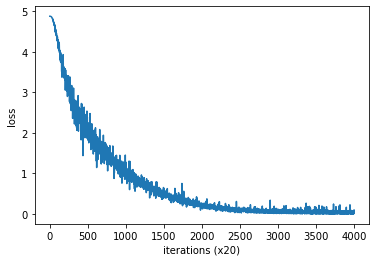

単語：ベクトル
when [-6.8770647 -7.1454096  4.474904  -7.0810747 -5.4723883]
i [-1.6057045 -6.97126   -6.5162888 -3.79985   10.765081 ]
was [-2.0535388  5.0197473  2.01162   -5.7407775  8.293773 ]
17, [-9.670448  -0.9526198  8.8324795 -3.6134517  6.934749 ]
read [ 2.0903006 -7.1945662 -4.4038653 -7.1826005 -5.997307 ]
a [ -3.474883  -11.670571   -5.0769296   5.6674714  -5.1088886]
quote [-1.2724111 -3.3097908 -6.2752438  6.393719   1.2386366]
that [ 9.925631   5.963295   9.61168    3.439245  -6.5250964]
went [-4.708414   9.077354   5.3166347 -3.2652369 10.143737 ]
something [ 5.148355   1.1230369 -1.6878511  1.7419177  4.769258 ]
like: [-3.9533784  -1.453008   -2.6933763  -6.801807   -0.24216631]
if [-0.78811836 11.051892    8.926592    2.5437398  -5.500062  ]
you [-9.95274   -0.6507598 -6.410348   8.033183   5.562026 ]
live [-5.113631  -0.6773763  6.1928368 -4.734543  -9.336435 ]
each [ 6.4155855 -2.53826   -8.7053385  8.156587  -5.851236 ]
day [-10.568734    3.6579633  -1.8297822   2.838349

In [11]:
#学習コードの実装
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "When I was 17, I read a quote that went something like: If you live each day as if it was your last, someday you’ll most certainly be right. It made an impression on me, and since then, for the past 33 years, I have looked in the mirror every morning and asked myself: “If today were the last day of my life, would I want to do what I am about to do today?” And whenever the answer has been “No” for too many days in a row, I know I need to change something.Remembering that I’ll be dead soon is the most important tool I’ve ever encountered to help me make the big choices in life. Because almost everything – all external expectations, all pride, all fear of embarrassment or failure – these things just fall away in the face of death, leaving only what is truly important. Remembering that you are going to die is the best way I know to avoid the trap of thinking you have something to lose. You are already naked. There is no reason not to follow your heart."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs

print("単語：ベクトル")
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

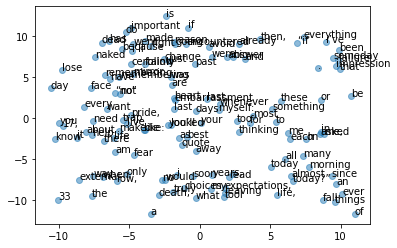

<Figure size 1440x1440 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (word_vecs[word_id, 0], word_vecs[word_id,1]))

plt.scatter(word_vecs[:,0], word_vecs[:,1], alpha=0.5)
plt.figure(figsize=(20,20))
plt.show()